In [2]:
!pip install opendatasets
!pip install pandas

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from keras.layers import TextVectorization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import opendatasets as od
import keras
from keras import layers
from sklearn.base import BaseEstimator
from nltk.corpus import stopwords

In [ ]:
def splitData(data:pd.DataFrame)->tuple:
    return train_test_split(data['sentence_str'], data['school'], test_size=0.25, random_state=42)

def getStopWords()->list:
    return stopwords.words('english')

def addNegationsToken(phrase:str)->str:
    phrase = re.sub(r"n't", " not", phrase)
    transformed = re.sub(r'\b(?:not|never|no)\b[\w\s]+',
                         lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)),
                         phrase,
                         flags=re.IGNORECASE)
    return transformed

def addNegationsToData(data:pd.DataFrame)->pd.DataFrame:
    data['sentence_str'] = data['sentence_str'].apply(addNegationsToken)
    return data

In [11]:
class RNN(BaseEstimator):
    def __init__(self, output_units, encoder, hidden_units=100):
        self.hidden_units = hidden_units
        self.encoder = encoder
        self.model = keras.Sequential([
            self.encoder,
            layers.Embedding(
            input_dim=len(self.encoder.get_vocabulary()),
            output_dim=128),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dense(activation='softmax', units=output_units) # 13 for the number of schools
        ])
        self.model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


    def fit(
        self,
        x=None,
        y=None,
        batch_size=None,
        epochs=1,
        verbose='auto',
        callbacks=None,
        validation_split=0.0,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1
    ):
        return self.model.fit(
            x=x,
            y=y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            validation_split=validation_split,
            validation_data=validation_data,
            shuffle=shuffle,
            class_weight=class_weight,
            sample_weight=sample_weight,
            initial_epoch=initial_epoch,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            validation_batch_size=validation_batch_size,
            validation_freq=validation_freq
            )


    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, Y):
        return self.model.evaluate(X, Y)

In [6]:
od.download(
    "https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy")

100%|██████████| 55.1M/55.1M [00:00<00:00, 87.7MB/s]


In [7]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

SCHOOLS = ['analytic','aristotle','german_idealism',
           'plato','continental','phenomenology',
           'rationalism','empiricism','feminism',
           'capitalism','communism','nietzsche',
           'stoicism']

def scorePhilosophy(prediction: 'list[str]', ground_truth: 'list[str]', saveName:str=None, showConfusionMatrix:bool=False) -> None:
    cm = confusion_matrix(ground_truth, prediction, labels=SCHOOLS, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SCHOOLS)
    disp.plot()
    plt.gcf().set_size_inches(12, 12)
    plt.xticks(rotation=45)
    if saveName:
        plt.savefig(saveName, dpi=300)
    if showConfusionMatrix:
        plt.show()
    #classificaiton report
    print(classification_report(ground_truth, prediction, target_names=SCHOOLS))
    print(f"micro f1: {f1_score(ground_truth, prediction, average='micro'):.2f}")
    print(f"micro precision: {precision_score(ground_truth, prediction, average='micro'):.2f}")
    print(f"micro recall: {recall_score(ground_truth, prediction, average='micro'):.2f}")

def splitData(data:pd.DataFrame, test_size=0.25)->tuple:
    return train_test_split(data['sentence_str'], data['school'], test_size=test_size, random_state=42)

def filterShortPhrases(data:pd.DataFrame, numWords)->pd.DataFrame:
    return data[data['sentence_str'].apply(lambda x: len(x.split())>numWords)]

In [8]:
def getData(validation_size:float=0.2, test_size:float=0.1)-> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv('history-of-philosophy/philosophy_data.csv')
    development, test = train_test_split(df, test_size=test_size, stratify=df['school'], random_state=42, shuffle=True)
    #split vslidation ant train from train
    if validation_size == 0:
        return development, None, test
    train, validation = train_test_split(development, test_size=validation_size/(1 - test_size), stratify=development['school'], random_state=42, shuffle=True)
    return train, validation, test

In [9]:
train, validation, test = getData()
df = pd.read_csv('history-of-philosophy/philosophy_data.csv')

x_train, y_train = train['sentence_str'], train['school']
x_val, y_val = validation['sentence_str'], validation['school']
x_test, y_test = test['sentence_str'], test['school']

lb_encoder = LabelEncoder()
y_train = lb_encoder.fit_transform(y_train)
y_train = to_categorical(y_train)
y_val = lb_encoder.fit_transform(y_val)
y_val = to_categorical(y_val)
y_test = lb_encoder.transform(y_test)
y_test = to_categorical(y_test)

unique_words = set()
for sentence in df['sentence_str']:
    unique_words.update(sentence.split())

encoder = TextVectorization(max_tokens=len(unique_words), output_mode='int', pad_to_max_tokens=True)
encoder.adapt(list(unique_words))

In [12]:
rnn = RNN(output_units = 13, encoder = encoder, hidden_units = 30)
rnn.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         12185600  
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 13)                845       
                                                                 
Total params: 12227661 (46.64 MB)
Trainable params: 12227661 (46.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = rnn.fit(x_train, y_train, epochs = 3, batch_size = 128,  validation_data = (x_val,y_val))

2256/2256 [==============================] - 14s 6ms/step


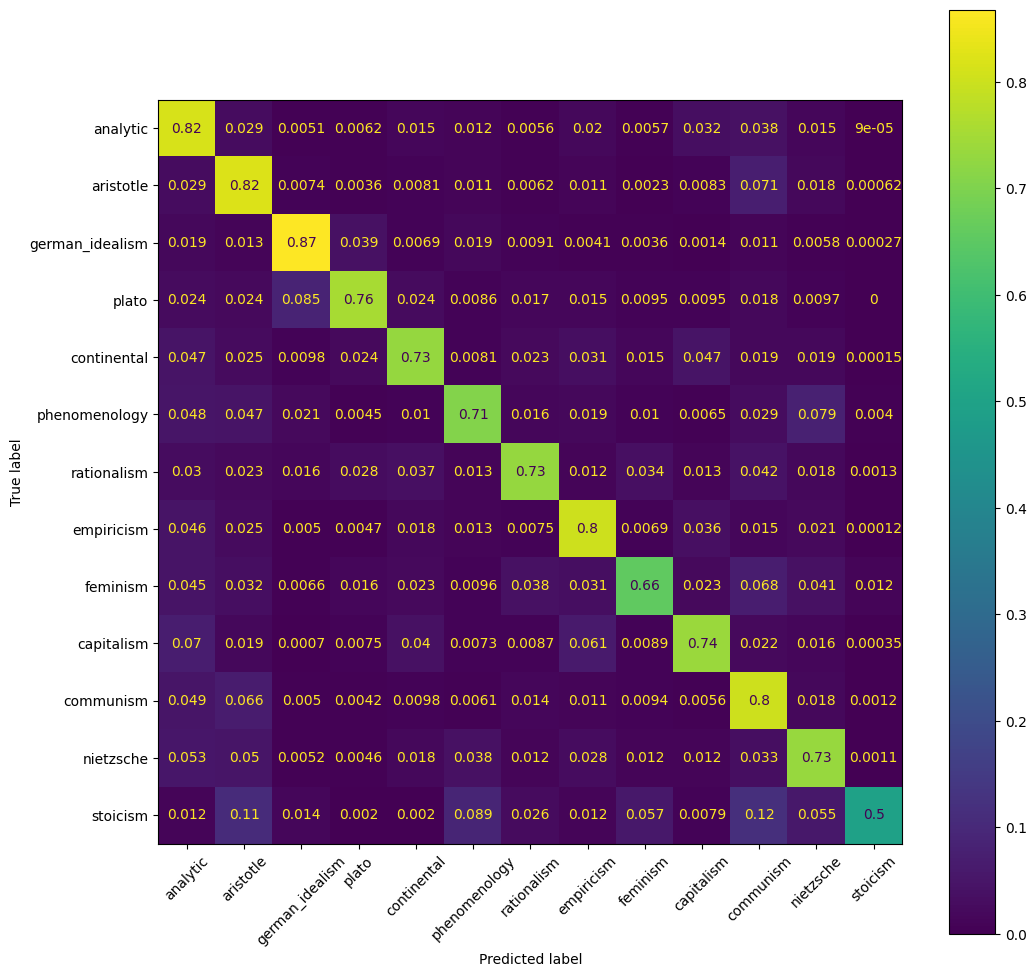

                 precision    recall  f1-score   support

       analytic       0.78      0.82      0.80     11085
      aristotle       0.79      0.82      0.81      9756
german_idealism       0.76      0.74      0.75      5715
          plato       0.73      0.80      0.76      7673
    continental       0.81      0.73      0.77      6756
  phenomenology       0.83      0.80      0.82      8427
    rationalism       0.73      0.66      0.69      2709
     empiricism       0.80      0.87      0.83      3639
       feminism       0.70      0.73      0.71      4590
     capitalism       0.76      0.71      0.73      3986
      communism       0.79      0.76      0.77      3592
      nietzsche       0.77      0.73      0.75      3727
       stoicism       0.76      0.50      0.60       507

       accuracy                           0.78     72162
      macro avg       0.77      0.74      0.75     72162
   weighted avg       0.78      0.78      0.78     72162

micro f1: 0.78
micro precisi

In [ ]:
predictions = rnn.predict(x_val)
predictions = np.argmax(predictions, axis=1)
predictions = [SCHOOLS[pred] for pred in predictions]
y_val = np.argmax(y_val, axis=1)
y_val = [SCHOOLS[pred] for pred in y_val]

scorePhilosophy(predictions, y_val, "cm", True)

In [ ]:
rnn.model.save("modelvero.keras")

In [1]:
rnn.model.summary()

NameError: name 'rnn' is not defined